In [23]:
import stan
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt

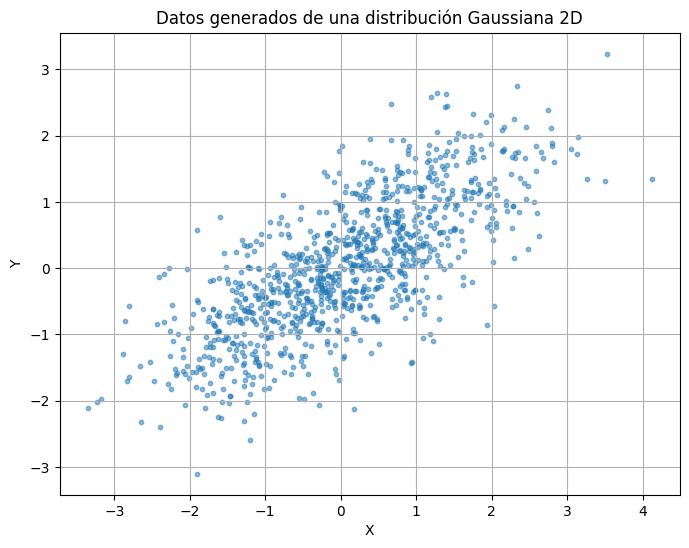

In [2]:
# Definir parámetros de la distribución gaussiana 2D
mean = [0, 0]               # Media en el origen
cov_matrix = [[1.5, 0.9],     # Matriz de covarianza
              [0.9, 1]]

# Generar datos
num_points = 1000
data_points = np.random.multivariate_normal(mean, cov_matrix, num_points)

# Graficar los datos generados
plt.figure(figsize=(8, 6))
plt.scatter(data_points[:, 0], data_points[:, 1], s=10, alpha=0.5)
plt.title('Datos generados de una distribución Gaussiana 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


In [3]:
# Definir parámetros de la distribución gaussiana 2D
mean = [0, 0]               # Media en el origen
cov_matrix_true = [[1.5, 0.9], # Matriz de covarianza
                   [0.9, 1]]

num_points = 1000
data_real = np.random.multivariate_normal(mean, cov_matrix_true, num_points)
datos = data_real.reshape((num_points, 2))

# Modelo Stan
stan_code = """
data {
    int<lower=0> N;              // Número de puntos
    matrix[N, 2] score;          // Datos observados (x, y)
}

parameters {
    cov_matrix[2] covariance_matrix;     // Matriz de covarianza a inferir
    vector[2] mu;                      // Media de la distribución gaussiana
}

model {
    // Prior sobre la matriz de covarianza
    covariance_matrix ~ wishart(2, diag_matrix(rep_vector(1.0, 2)));

    // Prior sobre la media mu
    mu[1] ~ normal(0, 0.5);
    mu[2] ~ normal(0, 0.5);
    // Likelihood: distribución gaussiana multivariante
    for (n in 1:N) {
        target += multi_normal_lpdf(score[n] | mu, covariance_matrix);
    }
}

generated quantities {
    matrix[N, 2] y_rep;  // Réplicas generadas de los datos
    for (n in 1:N) {
        vector[2] y_rep_n = multi_normal_rng(mu, covariance_matrix);
        y_rep[n, 1] = y_rep_n[1];
        y_rep[n, 2] = y_rep_n[2];
    }
}

"""

# Datos para Stan
data_stan = {
    'N': num_points,
    'score': datos
}

# Compilar el modelo
stan_model = stan.build(stan_code, data=data_stan, random_seed=0)

# Ajustar el modelo con valores iniciales específicos para cada cadena
num_chains = 5
init_values = [{
    'covariance_matrix': np.matrix(cov_matrix_true) + np.ones((2, 2))/4,  #me corro un poco del valor real, no cambia mucho igual esto.
    'mu': np.zeros(2) 
} for _ in range(num_chains)]

fit = stan_model.sample(num_chains=num_chains, num_samples=1000,init=init_values) #, init=init_values

# Resumen del ajuste
df = fit.to_frame()
df

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   1% (101/10000)
Sampling:   2% (201/10000)
Sampling:   3% (301/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  34% (3400/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  44% (4400/10000)
Sampling:  57% (5700/10000)
Sampling:  70% (7000/10000)
Sampling:  81% (8100/10000)
Sampling:  92% (9200/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000742 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.42 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is -4.86173e-63. (in '/tmp/httpstan_3pgitc_9/model_ll44cm6u.stan', line 14, column 4 to column 68)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Messag

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,covariance_matrix.1.1,covariance_matrix.2.1,covariance_matrix.1.2,...,y_rep.991.2,y_rep.992.2,y_rep.993.2,y_rep.994.2,y_rep.995.2,y_rep.996.2,y_rep.997.2,y_rep.998.2,y_rep.999.2,y_rep.1000.2
draws,,,,,,,,,,,,,,,,,,,,,
0,-2644.015124,0.991544,0.479503,4.0,15.0,0.0,2647.163542,1.578337,0.987439,0.987439,...,-2.232049,0.338812,-1.008993,1.299906,0.042463,1.622810,1.291825,-0.831396,0.072613,0.440942
1,-2641.952046,1.000000,0.474080,3.0,7.0,0.0,2642.839400,1.464808,0.884977,0.884977,...,0.208052,-0.284893,1.797264,1.365011,1.162901,-1.010271,-0.275315,-0.777533,0.881302,2.204761
2,-2641.282430,1.000000,0.472290,3.0,7.0,0.0,2644.302156,1.521599,0.960834,0.960834,...,-0.249699,0.684313,0.346737,-0.487831,-0.566376,0.920817,-2.245146,-1.112744,0.146936,-0.134435
3,-2640.959753,0.978401,0.573787,3.0,7.0,0.0,2642.180655,1.433305,0.911868,0.911868,...,-1.333322,-0.960485,0.231471,0.742582,1.974361,-0.098446,0.053035,0.288568,0.662887,0.798190
4,-2642.436647,0.976236,0.483258,3.0,7.0,0.0,2644.573441,1.465424,0.908659,0.908659,...,-0.466209,-0.962180,-0.675462,1.573051,-0.214900,-0.756799,0.386847,-1.567213,0.204332,1.550642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-2640.646028,0.901400,0.479503,3.0,7.0,0.0,2645.641793,1.427944,0.895359,0.895359,...,1.748749,0.911292,-0.470902,-0.058359,0.414237,0.631247,0.203829,0.172694,-1.146755,-0.933628
4996,-2643.889856,0.973190,0.474080,3.0,7.0,0.0,2645.314082,1.491779,0.963403,0.963403,...,1.711208,-0.808830,0.727221,-1.047645,-2.426192,-0.610584,0.451836,0.454233,0.485624,-0.025135
4997,-2642.984470,0.967848,0.472290,3.0,7.0,0.0,2644.955706,1.544404,0.961603,0.961603,...,0.995236,0.099175,-1.994437,-0.482661,0.360352,-0.522722,-0.991607,1.319476,0.279301,-0.730471


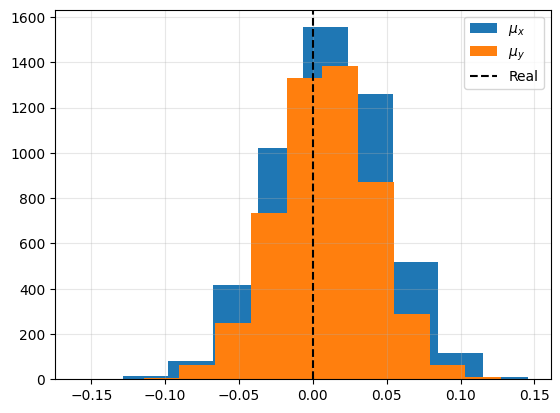

In [27]:
plt.hist(df['mu.1'], label= '$\mu_x$')
plt.hist(df['mu.2'], label= '$\mu_y$')
plt.axvline(0,ls='--', color= 'black',label = 'Real')
plt.legend()
plt.grid(alpha=0.3)

In [5]:
y_rep = fit['y_rep']
y_rep.shape

(1000, 2, 5000)

In [6]:
# Organizar los datos replicados
data_x_rep = y_rep[:, 0, :].flatten()
data_y_rep = y_rep[:, 1, :].flatten()

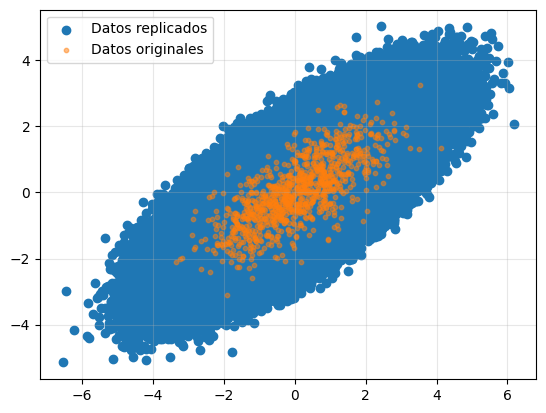

In [7]:
plt.scatter(data_x_rep,data_y_rep,label = 'Datos replicados')
plt.scatter(data_points[:, 0], data_points[:, 1], s=10, alpha=0.5,label = 'Datos originales')
plt.legend()
plt.grid(alpha=0.3)

In [28]:
len(data_x_rep)

5000000

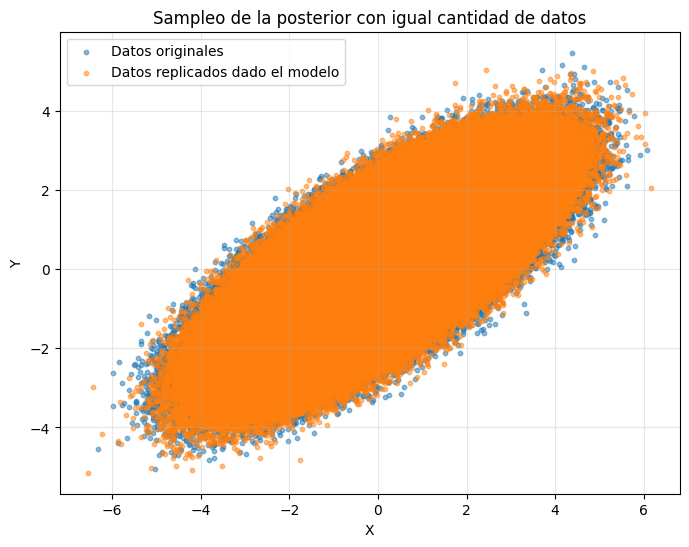

In [29]:
# Definir parámetros de la distribución gaussiana 2D
mean = [0, 0]               # Media en el origen
cov_matrix = [[1.5, 0.9],     # Matriz de covarianza
              [0.9, 1]]

# Generar datos
num_points_xxl = len(data_x_rep)
data_points_xxl = np.random.multivariate_normal(mean, cov_matrix, num_points_xxl)

# Graficar los datos
plt.figure(figsize=(8, 6))
plt.scatter(data_points_xxl[:, 0], data_points_xxl[:, 1], s=10, alpha=0.5,label = 'Datos originales')
plt.title('Sampleo de la posterior con igual cantidad de datos')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(alpha=0.3)

plt.scatter(data_x_rep,data_y_rep,s=10, alpha=0.5,label='Datos replicados dado el modelo')
plt.legend()

In [10]:
from scipy.stats import multivariate_normal
# Distribución normal multivariada para la densidad de probabilidad (por suerte tengo una densidad de probabilidad, sino hay que sumar de forma discreta, ver el bineado que genera la distribución)
mvn = multivariate_normal(mean=mean, cov=cov_matrix_true)

# Calcular la densidad de probabilidad de los datos
log_prob_data = np.sum(np.log(mvn.pdf(data_real)))
log_prob_data

-2641.8553046143643

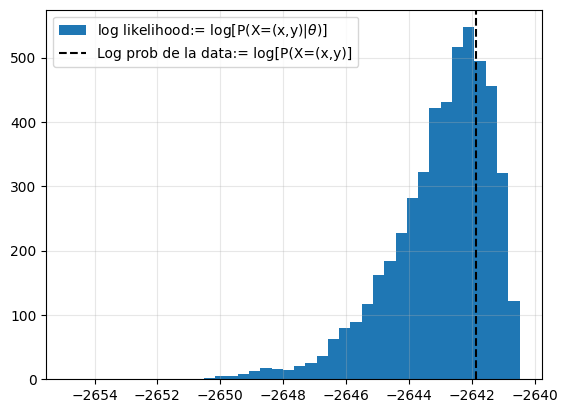

In [11]:
plt.hist(df['lp__'],bins=40, label = r'log likelihood:= log[P(X=(x,y)|$\theta$)]')
plt.axvline(log_prob_data, color = 'black', ls = '--',label='Log prob de la data:= log[P(X=(x,y)]')
plt.legend()
plt.grid(alpha=0.3)

In [12]:
round(df['covariance_matrix.1.1'].mean(),3), '+-' ,round(np.std(df['covariance_matrix.1.1']),3)

(1.453, '+-', 0.065)

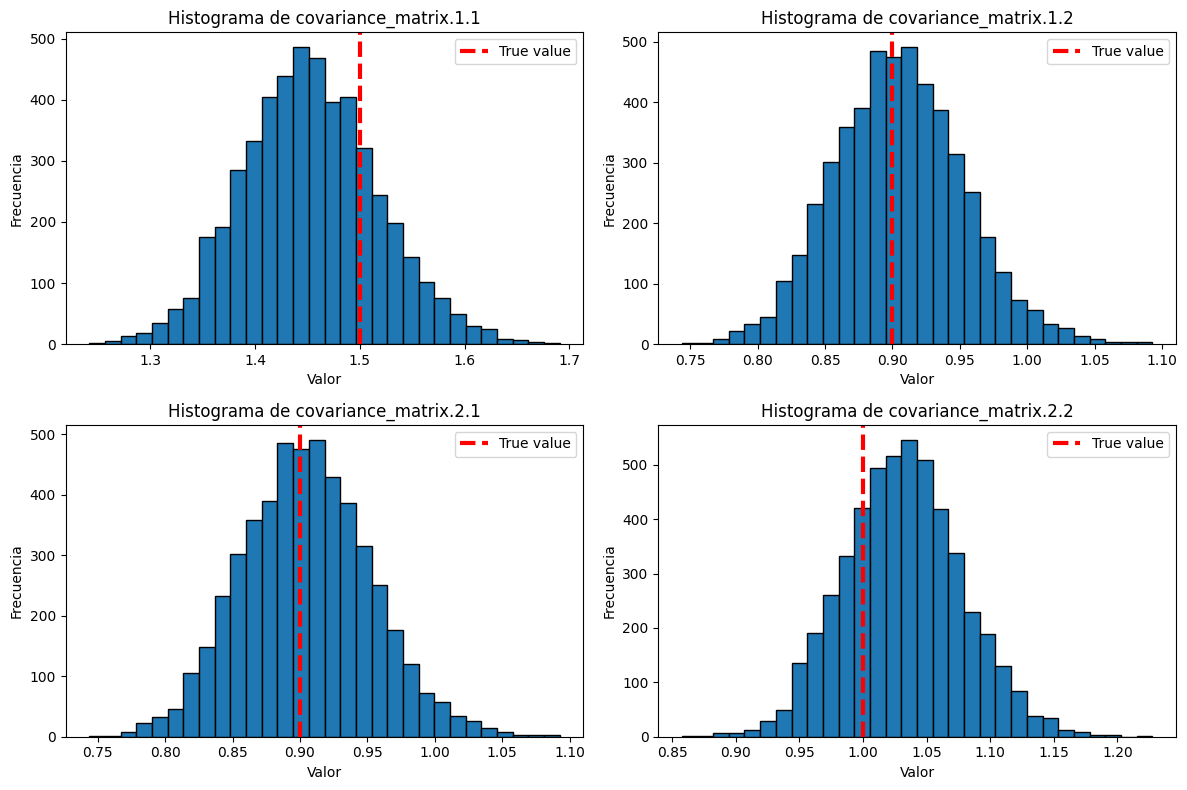

In [22]:
covariance_11 = df['covariance_matrix.1.1']
covariance_12 = df['covariance_matrix.1.2']
covariance_21 = df['covariance_matrix.2.1']
covariance_22 = df['covariance_matrix.2.2']

# Crear figura y subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Configurar los subplots
axs[0, 0].hist(covariance_11, bins=30, edgecolor='black')
axs[0, 0].set_title('Histograma de covariance_matrix.1.1')
axs[0, 0].set_xlabel('Valor')
axs[0, 0].set_ylabel('Frecuencia')
axs[0, 0].axvline(1.5,ls = '--', lw = 3,color = 'r',label = 'True value')
axs[0, 0].legend()

axs[0, 1].hist(covariance_12, bins=30, edgecolor='black')
axs[0, 1].set_title('Histograma de covariance_matrix.1.2')
axs[0, 1].set_xlabel('Valor')
axs[0, 1].set_ylabel('Frecuencia')
axs[0, 1].axvline(0.9,ls = '--', lw = 3,color = 'r',label = 'True value')
axs[0, 1].legend()

axs[1, 0].hist(covariance_21, bins=30, edgecolor='black')
axs[1, 0].set_title('Histograma de covariance_matrix.2.1')
axs[1, 0].set_xlabel('Valor')
axs[1, 0].set_ylabel('Frecuencia')
axs[1, 0].axvline(0.9,ls = '--', lw = 3,color = 'r',label = 'True value')
axs[1, 0].legend()

axs[1, 1].hist(covariance_22, bins=30, edgecolor='black')
axs[1, 1].set_title('Histograma de covariance_matrix.2.2')
axs[1, 1].set_xlabel('Valor')
axs[1, 1].set_ylabel('Frecuencia')
axs[1, 1].axvline(1,ls = '--', lw = 3,color = 'r',label = 'True value')
axs[1, 1].legend()




# Ajustar espaciado entre subplots
plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Parámetros de las distribuciones normales
n_samples_per_segment = 250  # Aproximadamente un tercio para cada segmento
std_dev = 2

# Primera parte de la "N": desde (x, y) = (-5, -15) a (0, 0)
x1 = np.linspace(-5, 0, n_samples_per_segment)
y1 = 3 * x1 + 0 + np.random.normal(0, std_dev, n_samples_per_segment)

# Segunda parte de la "N": desde (x, y) = (0, 0) a (5, -15)
x2 = np.linspace(0, 5, n_samples_per_segment)
y2 = -3 * x2 + np.random.normal(0, std_dev, n_samples_per_segment)

# Tercera parte de la "N": desde (x, y) = (5, -15) a (10, 15)
x3 = np.linspace(5, 10, n_samples_per_segment)
y3 = 3 * x3 - 30 + np.random.normal(0, std_dev, n_samples_per_segment)

# Concatenar los segmentos para formar la "N"
x = np.concatenate((x1, x2, x3))
y = np.concatenate((y1, y2, y3))

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos
plt.scatter(x, y, color='blue', alpha=0.5)

plt.xlim(-5.5,10.5)

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data sintética')
plt.grid(True)


#plt.savefig('Data 1 cruda.png')
# Mostrar el gráfico
plt.show()

data = np.array([x, y])


data = np.array([x, y]).T  # Transponer para obtener un array de puntos (x, y)

# Aplicar k-means clustering
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=10000,random_state=0)
kmeans.fit(data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos con colores según los clusters
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)

# Graficar los centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)

#plt.savefig('Data 1 clustering k=3.png')

# Imprimir los centroides
print("Centroids:")
print(centroids)
# Aplicar el algoritmo del codo
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

inertias = np.array(inertias)/3500  #a ojo ese 3500 solo para que quede bien el circulito rojo y no una super elipse
# Crear el gráfico del método del codo
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_values, np.array(inertias), 'bo-')
ax.set_xlabel('Número de clusters, k')
ax.set_ylabel('Inercia')
ax.set_title('Método del Codo para Encontrar el k Óptimo')



circle = plt.Circle((k_values[3], inertias[3]), 0.2, color='r',clip_on=False,fill=False)
ax.set_xticks(k_values)
ax.add_patch(circle)
ax.grid(True)
#plt.savefig('Data 1 kmeans barrido en k.png')
# Aplicar k-means clustering
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=10000,random_state=0)
kmeans.fit(data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos con colores según los clusters
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)

# Graficar los centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)

#plt.savefig('Data 1 clustering k=4.png')

# Imprimir los centroides
print("Centroids:")
print(centroids)
Nueva data generada a partir de gaussianas 2D
# Parámetros de la primera distribución
mean1 = [-2, -7.5]
theta1 = np.arctan(3)   #PENDIENTE 3, VIENE DE LA RECTA "y=3x"
c1, s1 = np.cos(theta1), np.sin(theta1)
R1 = np.array([[c1, -s1], [s1, c1]])  #MATRIZ DE ROTACIÓN
Lambda = np.diag([5, 0.25])    #VARIANZA EN EJES PRINCIPALES, LUEGO ROTO
cov1 = R1 @ Lambda @ R1.T

# Parámetros de la segunda distribución
mean2 = [2.5, -7.5]
theta2 = np.arctan(-3)
c2, s2 = np.cos(theta2), np.sin(theta2)
R2 = np.array([[c2, -s2], [s2, c2]])
cov2 = R2 @ Lambda @ R2.T

# Parámetros de la tercera distribución
mean3 = [7.2, -7.2]
cov3 = cov1  # Es la misma que la primera distribución

# Generar puntos
num_points = 250
points1 = np.random.multivariate_normal(mean1, cov1, num_points)
points2 = np.random.multivariate_normal(mean2, cov2, num_points)
points3 = np.random.multivariate_normal(mean3, cov3, num_points)

# Concatenar los datos x e y de cada gaussiana
x_all = np.concatenate((points1[:, 0], points2[:, 0], points3[:, 0]))
y_all = np.concatenate((points1[:, 1], points2[:, 1], points3[:, 1]))


# Graficar los puntos
plt.figure(figsize=(10, 6))
plt.grid()

#Esto para ver la data labeleada
#plt.scatter(points1[:, 0], points1[:, 1], s=10, alpha=0.5, label='Gaussian 1')
#plt.scatter(points2[:, 0], points2[:, 1], s=10, alpha=0.5, label='Gaussian 2')
#plt.scatter(points3[:, 0], points3[:, 1], s=10, alpha=0.5, label='Gaussian 3')


plt.scatter(x_all, y_all, s=25, color = 'blue', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best')
plt.title('Data2')
plt.xlim(-4.5,10.5)
plt.ylim(-14,-1.5)

#plt.savefig('Data 2 cruda.png')



data2 = np.array([x_all, y_all]).T  # Transponer para obtener un array de puntos (x, y)

# Aplicar k-means clustering
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=10000,random_state=0)
kmeans.fit(data2)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Ordenar la lista de centroides por el primer valor de cada elemento (elemento_i[0])
Centroids_sorted = sorted(centroids, key=lambda x: x[0])

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos con colores según los clusters
plt.scatter(data2[:, 0], data2[:, 1], c=labels, cmap='viridis', alpha=0.5)

# Graficar los centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)


#plt.savefig('Data 2 clustering k=3.png')

# Imprimir los centroides
print("Centroids:")
print(Centroids_sorted[0])
print(Centroids_sorted[1])
print(Centroids_sorted[2])

print(f'Los valores reales de los mu son: \nmu1 = {mean1} \nmu2 = {mean2} \nmu3 = {mean3}')
# Aplicar el algoritmo del codo
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data2)
    inertias.append(kmeans.inertia_)

inertias = np.array(inertias)/3200  #a ojo ese 3200 solo para que quede bien el circulito rojo y no una super elipse
# Crear el gráfico del método del codo
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_values, np.array(inertias), 'bo-')
ax.set_xlabel('Número de clusters, k')
ax.set_ylabel('Inercia')
ax.set_title('Método del Codo para Encontrar el k Óptimo')



circle = plt.Circle((k_values[2], inertias[2]), 0.2, color='r',clip_on=False,fill=False)
circle2 = plt.Circle((k_values[1], inertias[1]), 0.2, color='r',clip_on=False,fill=False)

# Agregar un signo de interrogación cerca del círculo
ax.annotate('?', (k_values[2] + 0.25, inertias[2] + 0.1), fontsize=15, color='black', weight='bold')

ax.set_xticks(k_values)
ax.add_patch(circle)
#ax.add_patch(circle2)
ax.grid(True)

#plt.savefig('Data 2 kmeans barrido en k.png')

# Aplicar k-means clustering
kmeans = KMeans(n_clusters=2, n_init=100, max_iter=10000,random_state=0)
kmeans.fit(data2)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos con colores según los clusters
plt.scatter(data2[:, 0], data2[:, 1], c=labels, cmap='viridis', alpha=0.5)

# Graficar los centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)

#plt.savefig('Data 2 clustering k=2.png')

# Imprimir los centroides
print("Centroids:")
#print(centroids[2]) #quedaron desordenados pero bueno, es lo mismo.
#print(centroids[0])
#print(centroids[1])
#print(f'Los valores reales de los mu son: \nmu1 = {mean1} \nmu2 = {mean2} \nmu3 = {mean3}')
# Aplicar k-means clustering
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=10000,random_state=0)
kmeans.fit(data2)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos con colores según los clusters
plt.scatter(data2[:, 0], data2[:, 1], c=labels, cmap='viridis', alpha=0.5)

# Graficar los centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)

#plt.savefig('Data 2 clustering k=4.png')

# Imprimir los centroides
print("Centroids:")
print(centroids[2]) #quedaron desordenados pero bueno, es lo mismo.
print(centroids[0])
print(centroids[1])
print(f'Los valores reales de los mu son: \nmu1 = {mean1} \nmu2 = {mean2} \nmu3 = {mean3}')
#Comparación de data1 y data2
plt.figure(figsize=(10, 6))

plt.scatter(x, y, s=40, color='blue', alpha=0.5,label='Data 1')
plt.scatter(x_all, y_all, s=40, color = 'green', alpha=0.5, label='Data 2')
plt.legend()
plt.ylim(bottom=-18)
plt.xlabel('x')
plt.xlabel('y')
plt.title('Comparación entre datas')
print(len(y_all),len(y))
plt.grid()

#plt.savefig('Comparacion entre datas.png')
Pasemos a inferencia bayesiana
#ESTA HECHO EN EL JUPYTER DE LA VPN